In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
# import rasterio

# mapping utilities
# import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator

import flopy
import flopy.utils.binaryfile as bf


In [2]:
git_dir = os.getcwd()
while os.path.basename(git_dir) != 'GitHub':
    git_dir = os.path.dirname(git_dir)
usr_dir = os.getcwd()
while os.path.basename(usr_dir) != 'Users':
    temp = os.path.basename(usr_dir)
    usr_dir = os.path.dirname(usr_dir)
usr_dir += '/'+temp

py_dir = git_dir +'/CosumnesRiverRecharge/python_utilities/'
## Set up directory referencing
# Package data
gwfm_dir = usr_dir+'/Box/research_cosumnes/GWFlowModel/'
gwfm_dir
bas_dir = gwfm_dir + 'BAS6/'
proj_dir = gwfm_dir+'Levee_setback/'
plt_dir = proj_dir+'figures/'


## Pick model type to review
RIV is the simple model with only SS assumptions about Blodgett Dam depth and area
LAK is the complex model with interactive flow between the stream and Blodgett Dam

In [3]:
# run_dir = 'C://WRDAPP/GWFlowModel'
run_dir = 'F://WRDAPP/GWFlowModel'
loadpth = run_dir +'/Cosumnes/levee_setback/streamflow/'

# runs = os.listdir(loadpth)
# runs
runs = ['setback_streamflow','historical_streamflow']


In [4]:
# model_ws =loadpth+'/actual_200cfs'

# i=0
# os.listdir(loadpth+runs[i])
# glob.glob(loadpth+runs[i]+'/*.nam')[0]
# model_ws = loadpth+runs[i]

# model_nam = 'setback_streamflow'
model_nam = 'historical_streamflow'


model_ws = loadpth+model_nam


In [5]:

# m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
#                                 exe_name='mf2005', version='mfnwt')

m_ss = flopy.modflow.Modflow.load('MF.nam', model_ws= loadpth+'historical_SS', 
                                exe_name='mf2005', version='mfnwt')

In [6]:
sfr_dir = gwfm_dir+'/SFR_data/'
grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
lak_grid_clip = gpd.read_file(proj_dir+'lak_grid_clip/lak_grid_clip.shp')


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError

In [7]:
def plot_head_simple(model, hdobj, cbb, spd_stp,time, name, ax, hk,units):
    hd_step = 5
    if units =='ft':
        fact = 0.3048
    elif units== 'm':
        fact=1
    head = hdobj.get_data(kstpkper = spd_stp)/fact
    levels_hmax = np.round(np.max(head[head!=1E+30/fact]),-1)
    levels_hmin = np.round(np.min(head[head>=-200/fact]),-1)
    levels = np.arange(levels_hmin, levels_hmax, int(hd_step/fact))


    ax.set_title(name+' Head Contours at '+ str(time))
    mapview = flopy.plot.PlotMapView(model=model,ax=ax)

    contour_set = mapview.contour_array(head, masked_values=[-999.99], levels=levels, ax=ax)
    hcb = plt.colorbar(contour_set, shrink = 0.5,ax=ax)
    hcb.set_label('Head ('+units+')')
    ax.clabel(contour_set, contour_set.levels[0::2], inline=True, fontsize=8)


    # plot the horizontal hydraulic conductivities
    if hk == True:
        a = model.lpf.hk.array
        csa = mapview.plot_array(a, norm=mpl.colors.LogNorm())
        cb = plt.colorbar(csa, shrink=0.75,ax=ax)
        cb.set_label('Horiz. Cond. (m/d)')
    # Plots boundary condtiions
#     quadmesh = mapview.plot_ibound(ax=ax)
    mapview.plot_bc("GHB", plotAll=True,ax=ax)
    mapview.plot_bc("SFR", plotAll=True,ax=ax)
    mapview.plot_bc("CHD", plotAll=True,ax=ax)
    mapview.plot_bc("WEL", plotAll=True,ax=ax,alpha=0.1, color='red')

#     quiver = mapview.plot_discharge(frf, fff, istep=10, jstep=10)  # no head array for volumetric discharge
    ax.ticklabel_format(style='plain')
#     linecollection = mapview.plot_grid(linewidths = 0.3,ax=ax)
    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
#     fig.tight_layout()

In [8]:
def plot_dtw_simple(model, hdobj, cbb, spd_stp,time, name, ax, hk,units):
    hd_step = 10
    if units =='ft':
        fact = 0.3048
    elif units== 'm':
        fact=1
    head = hdobj.get_data(kstpkper = spd_stp)/fact
    dtw = model.dis.top.array-head
    levels_dtw_max = np.round(np.max(dtw[head!=1E+30/fact]),-1)
    # filter out dtw greater than 300 because of mountain ranges
#     levels_dtw_max = 300
    levels_dtw_hmin = np.round(np.min(dtw[head>=-200/fact]),-1)
#     levels_dtw_hmin = -300
        #     frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
    #     fff = cbb.get_data(text='FLOW FRONT FACE')[0]

    levels = np.arange(levels_dtw_hmin, levels_dtw_max, int(hd_step/fact))

    ax.set_title(name+' DTW Contours at '+ str(time))
    mapview = flopy.plot.PlotMapView(model=model,ax=ax)
    
    contour_set = mapview.contour_array(dtw, masked_values=[-999.99], levels=levels, ax=ax)
    hcb = plt.colorbar(contour_set, shrink = 0.5,ax=ax)
    hcb.set_label('DTW ('+units+')')
    ax.clabel(contour_set, contour_set.levels[0::2], inline=True, fontsize=8)
#     ax.clabel(contour_set, contour_set.levels[0::2], inline=True, fontsize=8)

    # plot the horizontal hydraulic conductivities
    if hk == True:
        a = model.lpf.hk.array
        csa = mapview.plot_array(a, norm=mpl.colors.LogNorm())
        cb = plt.colorbar(csa, shrink=0.75,ax=ax)
        cb.set_label('Horiz. Cond. (m/d)')
    # Plots boundary condtiions
#     quadmesh = mapview.plot_ibound(ax=ax)
    mapview.plot_bc("SFR", plotAll=True,ax=ax)
    mapview.plot_bc("GHB", plotAll=True,ax=ax)
    mapview.plot_bc("CHD", plotAll=True,ax=ax)
    mapview.plot_bc("WEL", plotAll=True,ax=ax,alpha=0.1, color='red')

    
#     quiver = mapview.plot_discharge(frf, fff, istep=10, jstep=10)  # no head array for volumetric discharge
    ax.ticklabel_format(style='plain')
#     linecollection = mapview.plot_grid(linewidths = 0.3,ax=ax)
    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')


# Head plots and contours

In [9]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()
cbc = model_ws+'/MF.cbc'

strt_date = pd.to_datetime(m.dis.start_datetime)
dates = strt_date+(np.asarray(times)-1).astype('timedelta64[D]')

dt_ref = pd.DataFrame(dates, columns=['dt'])
dt_ref['kstpkper'] = spd_stp


NameError: name 'm' is not defined

In [10]:
hdobj_ss = flopy.utils.HeadFile(loadpth+'historical_SS/MF.hds')
# hdobj_ss = flopy.utils.HeadFile(loadpth+'historical_streamflow/MF.hds')
# temp = hdobj_ss.get_data((0,0))
# plt.imshow(temp[0,:,:])
# plt.colorbar()

In [229]:
# shapefile rectangle of the area surrounding the Dam within about 5 cells
zon_dam_gpd = gpd.read_file(gwfm_dir+'/Blodgett_Dam/geospatial/zon_bud_extent/zon_bud_extent.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')

zon_cells = gpd.sjoin(grid_p,zon_dam_gpd,how='right',op='within')
# zon_cells = gpd.sjoin(grid_p,zon_dam_gpd) #includes more cells, including with high conductance

# filter zone budget for Blodgett Dam to just within 5 cells or so of the Dam
# zon_dam = np.zeros((m.dis.nrow,m.dis.ncol),dtype=int)
zon_dam = np.zeros((grid_p.row.max(),grid_p.column.max()),dtype=int)

zon_dam[zon_cells.row-1,zon_cells.column-1]=1

zon_mod = np.ones((grid_p.row.max(),grid_p.column.max()),dtype=int)

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [230]:
# idx can be (layer, row, column)

zon_allk = np.repeat(np.arange(0,m.dis.nlay),len(zon_cells))
zon_alli = np.tile((zon_cells.row-1).values,m.dis.nlay)
zon_allj = np.tile((zon_cells.column-1).values,m.dis.nlay)
zon_allkij = list(zip(zon_allk,zon_alli,zon_allj))

dem_data = m.dis.top.array

In [ ]:
def gdf_2_lims(gdf,ax):
    xmin, ymin = gdf.geometry.bounds.loc[:,['minx','miny']].min()
    xmax, ymax = gdf.geometry.bounds.loc[:,['maxx','maxy']].max()
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)

In [214]:
event_dates = ['2019-01-01','2019-02-01','2019-03-01','2019-04-01','2019-05-01','2019-06-01']
post_dates = ['2019-7-01','2019-8-01','2019-9-01','2019-10-01']
event_spd = dt_ref.set_index('dt').loc[event_dates].values
post_spd = dt_ref.set_index('dt').loc[post_dates].values

In [233]:
zon_hd = hdobj.get_data(kstpkper=(0,0))
zon_ts = hdobj.get_ts(idx=zon_allkij)

In [234]:
start_date = pd.to_datetime(m.dis.start_datetime)- np.ones(1).astype('timedelta64[D]')

Text(0, 0.5, 'Groundwater Elevation (m)')

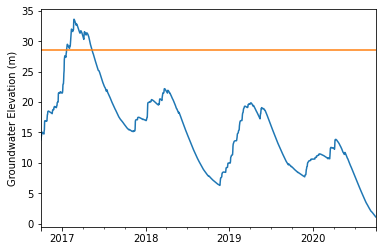

In [235]:
ts_df = pd.DataFrame(zon_ts, columns = ['totim']+zon_allkij)
ts_df = ts_df.set_index('totim')
ts_df.index =  start_date + ts_df.index.values.astype('timedelta64[D]')
ts_df.mean(axis=1).plot()

mean_dem = dem_data[(zon_cells.row-1).values,(zon_cells.column-1).values].mean()
plt.plot([ts_df.index.min(), ts_df.index.max()],[mean_dem,mean_dem], label='Mean Ground Surface Elevation')

plt.ylabel('Groundwater Elevation (m)')

In [236]:
ts_long = ts_df.melt(ignore_index=False,value_name='head_m')

ts_long = ts_long.reset_index().rename({'index':'Date'},axis=1)
ts_long['k'] = ts_long.variable.str[0].values
ts_long['i'] = ts_long.variable.str[1].values
ts_long['j'] = ts_long.variable.str[2].values
ts_long = ts_long.drop(['variable'],axis=1)
# get hk to help sort head by region
ts_long['hk'] = m.lpf.hk.array[ts_long.k,ts_long.i,ts_long.j]

n = ts_long.hk.quantile([0.76]).values
ts_long.loc[ts_long.hk.values<n,'facies'] = 'fine'
ts_long.loc[ts_long.hk.values>=n,'facies'] = 'coarse'

In [237]:
# ts_long.to_csv(plt_dir+'head_timeseries_'+model_nam+'.csv')
# ts_setback

In [242]:
# model_nam
# ts_long.set_index('k').loc[0].plot(x='Date',y='head_m')

'historical_streamflow'

In [193]:
sfr_ij = grid_sfr.loc[:,['row','column','z']]
sfr_ij.row = (sfr_ij.row-1).astype(int)
sfr_ij.column = (sfr_ij.column-1).astype(int)
ts_long_sfr = ts_long.join(sfr_ij.set_index(['row','column']),on=['i','j'],how='inner')
ts_long_sfr.loc[ts_long_sfr.k==0]

Date     head_m  k   i    j         hk          z
5856  2018-10-01  21.233633  0  52  149  21.035179  23.040833
5857  2018-10-02  21.515221  0  52  149  21.035179  23.040833
5858  2018-10-03  21.620865  0  52  149  21.035179  23.040833
5859  2018-10-04  21.491665  0  52  149  21.035179  23.040833
5860  2018-10-05  21.534966  0  52  149  21.035179  23.040833
...          ...        ... ..  ..  ...        ...        ...
64411 2020-09-27   8.884880  0  50  145  10.487630  22.719805
64412 2020-09-28   8.791301  0  50  145  10.487630  22.719805
64413 2020-09-29   8.691462  0  50  145  10.487630  22.719805
64414 2020-09-30   8.593722  0  50  145  10.487630  22.719805
64415 2020-10-01   8.502775  0  50  145  10.487630  22.719805

[8784 rows x 7 columns]

<AxesSubplot:xlabel='Date'>

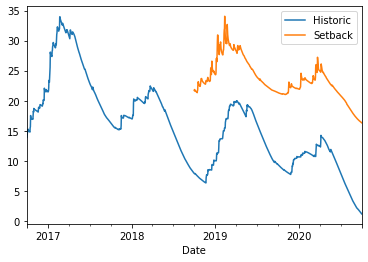

In [240]:
fig,ax=plt.subplots()
ts_lay_mean = ts_long.groupby(['k','Date'],as_index=False).mean()
ts_lay_mean.set_index('k').loc[0].plot(x='Date',y='head_m',ax=ax,label='Historic')

ts_lay_mean = ts_setback.groupby(['k','Date'],as_index=False).mean()
ts_lay_mean.set_index('k').loc[0].plot(x='Date',y='head_m',ax=ax,label='Setback')

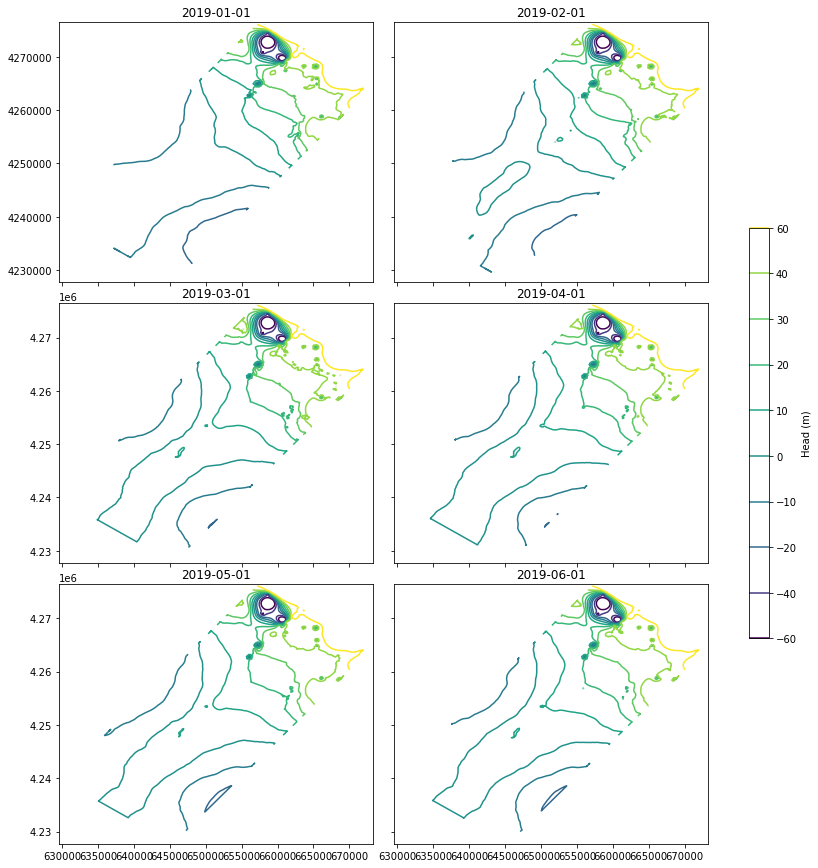

In [216]:
levels = [-60, -40,-20,-10,0,10,20,30,40,60]

fig,ax=plt.subplots(3,2,figsize=(12,12), sharex='col',sharey='row')
fig.tight_layout()
for n,plt_spd in enumerate(event_spd):
    ax_n =ax[int(n/2), n% 2]

    zon_hd = hdobj.get_data(kstpkper=plt_spd[0])
#     im = ax_n.imshow(zon_hd[0,:,:], vmin=0,vmax=40, cmap='viridis')
    mapview = flopy.plot.PlotMapView(model=m,ax=ax_n)
    contour_set = mapview.contour_array(zon_hd[0,:,:], masked_values=[-999.99], levels=levels, ax=ax_n)
#     contour_set = ax_n.contour(zon_hd[0,:,:], levels = levels,cmap='viridis')
    ax_n.set_title(event_dates[n])
hcb = plt.colorbar(contour_set, shrink = 0.5,ax=ax)
hcb.set_label('Head (m)')
ax[0,0].ticklabel_format(style='plain')

# ax.clabel(contour_set, contour_set.levels[0::2], inline=True, fontsize=8)
# fig.colorbar(im)

In [30]:
zon_ts

array([[ 1.0000000e+00,  2.2997576e+01,  2.2997576e+01, ...,
         1.5057780e+01,  1.7149073e+01,  1.1685107e+01],
       [ 2.0000000e+00,  2.2902262e+01,  2.2902262e+01, ...,
         1.5039334e+01,  1.7124102e+01,  1.1685183e+01],
       [ 3.0000000e+00,  2.2521807e+01,  2.2521807e+01, ...,
         1.5000693e+01,  1.7074703e+01,  1.1677019e+01],
       ...,
       [ 7.3000000e+02,  2.1740000e+01,  2.1740000e+01, ...,
         1.5907685e+00,  2.0592883e+00,  7.6481134e-02],
       [ 7.3100000e+02,  2.1740000e+01,  2.1740000e+01, ...,
         1.4863696e+00,  1.9646994e+00,  1.8254188e-03],
       [ 7.3200000e+02,  2.1740000e+01,  2.1740000e+01, ...,
         1.3813614e+00,  1.8682159e+00, -7.4258909e-02]], dtype=float32)

In [32]:
# this doesn't seem to have helped much
# dir_current = 'historical_streamflow'
# dir_2010 = 'historical_SS'
# head_current = np.zeros(m.dis.botm.shape)
# head_2010 = np.zeros(m.dis.botm.shape)

# for k in np.arange(0,m.dis.nlay):
#     head_current[k,:,:] = np.loadtxt(bas_dir+'steadystate_heads/'+dir_current+'/layer'+str(k)+'.tsv',delimiter='\t')
#     head_2010[k,:,:] = np.loadtxt(bas_dir+'steadystate_heads/'+dir_2010+'/layer'+str(k)+'.tsv',delimiter='\t')

In [39]:
# plt.imshow((head_current-head_2010)[0,:,:], vmin=-100)
# plt.colorbar()

In [10]:
# from os.path import basename
# # save steady state head to try to improve ss run time
# head_ss = hdobj.get_data((0,0))
# os.makedirs(bas_dir+'steadystate_heads/'+basename(model_ws), exist_ok=True)
# for k in np.arange(0,head_ss.shape[0]):
#     np.savetxt(bas_dir+'steadystate_heads/'+basename(model_ws)+'/layer'+str(k)+'.tsv', head_ss[k,:,:],delimiter='\t')

# Sim vs Obs Head


In [201]:
model_ws = loadpth+'historical_SS'
# model_ws = loadpth+'historical_streamflow'

In [202]:
hobout = pd.read_csv(model_ws+'/MF.hob.out',delimiter='\s+', header = 0,names = ['sim_val','WSE','obs_nam'],
                     dtype = {'sim_val':float,'obs_val':float,'obs_nam':object})
# if only one obs exists correct naming convention
one_obs = ~hobout.obs_nam.str.contains('.0')
hobout.loc[one_obs,'obs_nam'] = hobout.loc[one_obs,'obs_nam']+'.'+str(1).zfill(5)

<>:1: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
C:\Users\ajcalder\AppData\Local\Temp/ipykernel_155392/76628971.py:1: DeprecationWarning: invalid escape sequence \s
  hobout = pd.read_csv(model_ws+'/MF.hob.out',delimiter='\s+', header = 0,names = ['sim_val','WSE','obs_nam'],


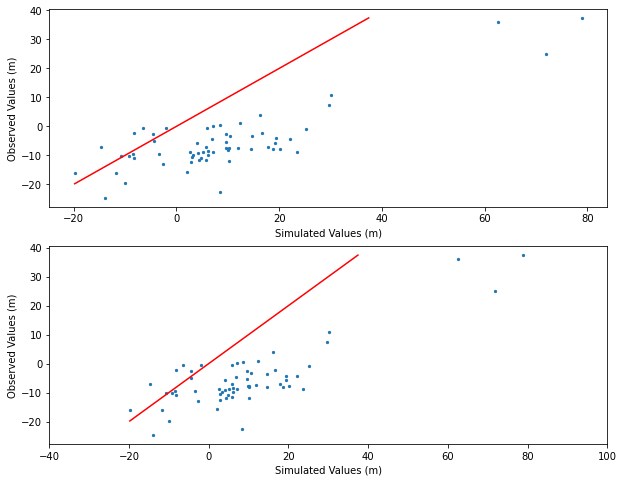

In [203]:
fig, ax = plt.subplots(2,1,figsize=(10,8))

# get boundary values for plotting a 1:1
hobmax = hobout.loc[:,['sim_val','WSE']].max().min()
hobmin = hobout.loc[:,['sim_val','WSE']].min().max()

# plot observed vs simulated values
hobout.plot.scatter(x='sim_val',y='WSE',marker='.',ax=ax[0])
ax[0].plot([hobmin,hobmax],[hobmin,hobmax],'red')
ax[0].set_ylabel('Observed Values (m)')
ax[0].set_xlabel('Simulated Values (m)')

hobout.plot.scatter(x='sim_val',y='WSE',marker='.',ax=ax[1])
ax[1].set_xlim(-40,100)

# plot 1:1 line
ax[1].plot([hobmin,hobmax],[hobmin,hobmax],'red')

plt.ylabel('Observed Values (m)')
plt.xlabel('Simulated Values (m)')

fig_nam = plt_dir+'GSP_WaterBudget/sim_vs_obs_heads'

# plt.savefig(fig_nam+'.png',dpi=600,bbox_inches='tight')
# plt.savefig(fig_nam+'.svg',dpi=600,bbox_inches='tight')

In [179]:
all_obs = pd.read_csv(model_ws+'/input_data/all_obs_grid_prepared.csv')


In [180]:
grid_p['easting'] = grid_p.geometry.centroid.x
grid_p['northing'] = grid_p.geometry.centroid.y

In [204]:
obs_data = hobout.join(all_obs.set_index('obs_nam'),on=['obs_nam'])
obs_data = obs_data.dropna(subset=['node'])
obs_data.loc[:,['row','column','node']] = obs_data.loc[:,['row','column','node']].astype(int)

# obs_data.index = obs_data.index
obs_grid = obs_data.join(grid_p.set_index(['row','column']).loc[:,['easting','northing']], 
                         on=['row','column'])
# # convert back to geospatial
hob_gpd = gpd.GeoDataFrame(obs_grid, geometry = gpd.points_from_xy(obs_grid.easting, obs_grid.northing))
hob_gpd['error'] = hob_gpd.WSE - hob_gpd.sim_val
hob_gpd['abs_error'] = hob_gpd.error.abs()
# set date


In [205]:
if 'MSMT_DATE' in hob_gpd.columns:
    hob_gpd = hob_gpd.set_index('MSMT_DATE')
    hob_gpd.index = pd.to_datetime(hob_gpd.index)    
#     groupby values by season
    hob_gpd.loc[(hob_gpd.index.month > 2)&(hob_gpd.index.month < 6),'season'] = 'spring'
    hob_gpd.loc[(hob_gpd.index.month > 8)&(hob_gpd.index.month < 12),'season'] = 'fall'
    
    hob_seasonal = hob_gpd.groupby(['node','season']).mean()
    hob_seasonal = gpd.GeoDataFrame(hob_seasonal, geometry = gpd.points_from_xy(hob_seasonal.easting, hob_seasonal.northing))
    hob_seasonal = hob_seasonal.reset_index()

In [206]:
hob_interest

sim_val     WSE       obs_nam  Unnamed: 0           SITE_CODE  \
2   123.886071 -0.6185  N17487.00001         2.0  382210N1213719W001   
10  150.839021 -2.5963   N9448.00001        10.0  382742N1214193W001   
12  167.914798 -0.4130   N6458.00001        12.0  382899N1214415W001   

         GWE   WLM_GSE   node  row  column  dem_elev  dem_wlm_gse  wse_m_adj  \
2  -0.618467  6.402439  17487   76       6  6.576871     0.174432  -0.444035   
10 -2.596297  4.375000   9448   41      17  5.144085     0.769085  -1.827212   
12 -0.413008  4.536585   6458   28      17  4.008222    -0.528363  -0.941371   

    spd        easting      northing                        geometry  \
2   0.0  642255.367532  4.231533e+06  POINT (642255.368 4231533.062)   
10  0.0  637999.337824  4.237510e+06  POINT (637999.338 4237510.202)   
12  0.0  635925.619074  4.239079e+06  POINT (635925.619 4239078.543)   

         error   abs_error  
2  -124.504571  124.504571  
10 -153.435321  153.435321  
12 -168.327798  168.327798

In [207]:
print('Upper Cosumnes - deep DTW expected')

hob_interest = hob_gpd.loc[hob_gpd.node.isin([14644, 15343, 16963])]
print('Simulated DTW (ft): ',(hob_interest.dem_elev - hob_interest.sim_val).values/0.3048)
print('Observed DTW (ft): ',(hob_interest.dem_elev - hob_interest.WSE).values/0.3048)

# hob_interest
print('Lower Cosumnes - shallow DTW expected')
hob_interest = hob_gpd.loc[hob_gpd.node.isin([9448, 6458, 17487])]
print('Simulated DTW (ft): ',(hob_interest.dem_elev - hob_interest.sim_val).values/0.3048)
print('Observed DTW (ft): ',(hob_interest.dem_elev - hob_interest.WSE).values/0.3048)

# hob_interest

Upper Cosumnes - deep DTW expected
Simulated DTW (ft):  [37.4976673  44.41751684 65.36976971]
Observed DTW (ft):  [143.91543722 130.26616205 139.11416875]
Lower Cosumnes - shallow DTW expected
Simulated DTW (ft):  [ 27.92931487 -14.54467017  -6.29110772]
Observed DTW (ft):  [23.60685974 25.39496297 14.50532291]


The error is slightly smaller than presented because I used the raw GWE which is based on the surveyed land surface elevation instead of the adjusted water surface elevation based on the model top elevation. Additionally these three wells are in a part of the basin with grassland/pasture that I was not simulating for pumping because it was such a large portion of the domain and it is difficult to know whether it is irrigated or not. It may need to be adjusted to allow pumping on pasture when it is near a domestic or agricultural well (say a radius of 1000 ft or 300 m). South of the Cosumnes water levels tend to be even lower than on the north side where perhaps Deer Creek provides more recharge.

<AxesSubplot:>

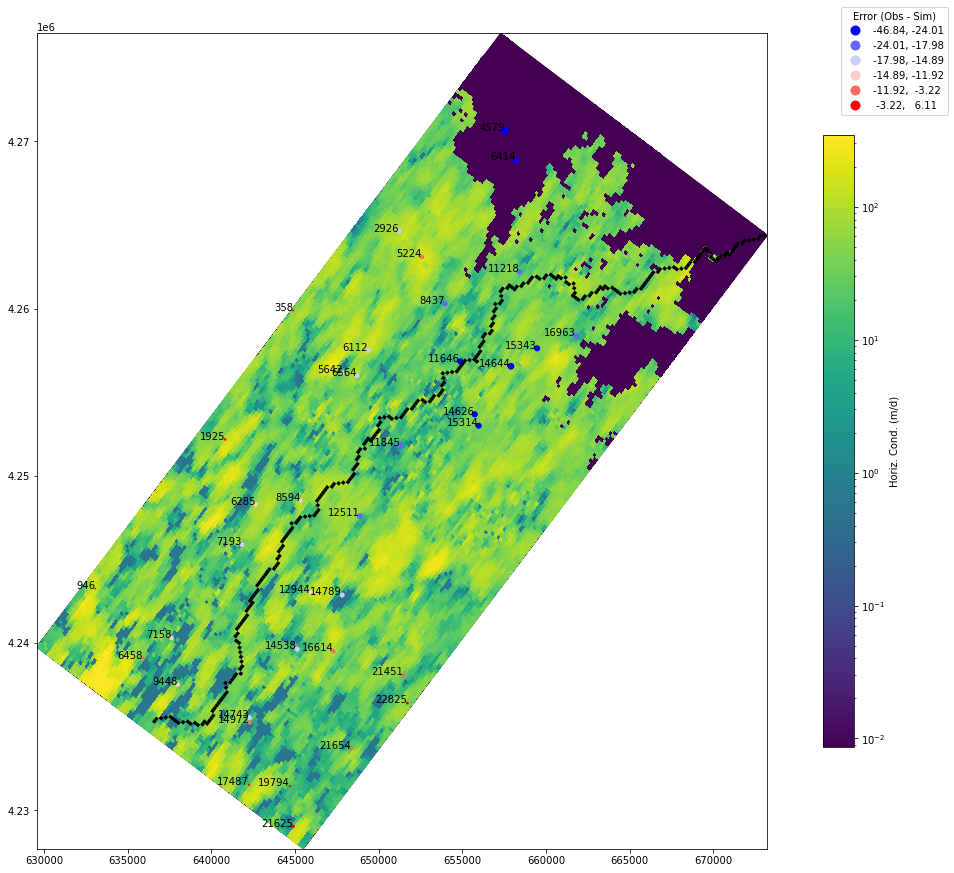

In [208]:
fig,ax=plt.subplots(figsize=(20, 15))

m_domain.plot(ax=ax,color='None')
mapview = flopy.plot.PlotMapView(model=m,ax=ax)
a = m.lpf.hk.array

csa = mapview.plot_array(a[0,:,:], norm=mpl.colors.LogNorm())
cb = plt.colorbar(csa, shrink=0.75,ax=ax)
cb.set_label('Horiz. Cond. (m/d)')

# hob_gpd.plot('error',scheme='EqualInterval', k= 6, ax=ax,legend=True,cmap='magma')
hob_gpd.plot('error',markersize='abs_error',scheme='Quantiles', k = 6, ax=ax,
                  legend=True,cmap='bwr',legend_kwds={'loc':(1.1,0.9),'title':'Error (Obs - Sim)'})
# hob_gpd.apply(lambda x: ax.annotate(str(x.node), xy=x.geometry.centroid.coords[0], ha='right'),axis=1);
hob_gpd.apply(lambda x: ax.annotate(str(x.node), xy=list(x.geometry.coords)[0], ha='right'),axis=1);

grid_sfr.plot(ax=ax,color='black')
# ax.legend(loc=(1,0.5))

In [163]:
hobs_long = (hob_gpd.groupby('SITE_CODE').count()>=int(m.dis.nper/365)*2)
hobs_long = hobs_long.index[hobs_long.WSE].values
# hobs_long.shape


array([20285, 22825, 21451, 16614, 10384, 20308,  7158, 10165, 12944,
       13407,   946, 15314,  6085, 14626,  6564, 15343, 16963,  9580,
        8437, 11218,   183,  5056])

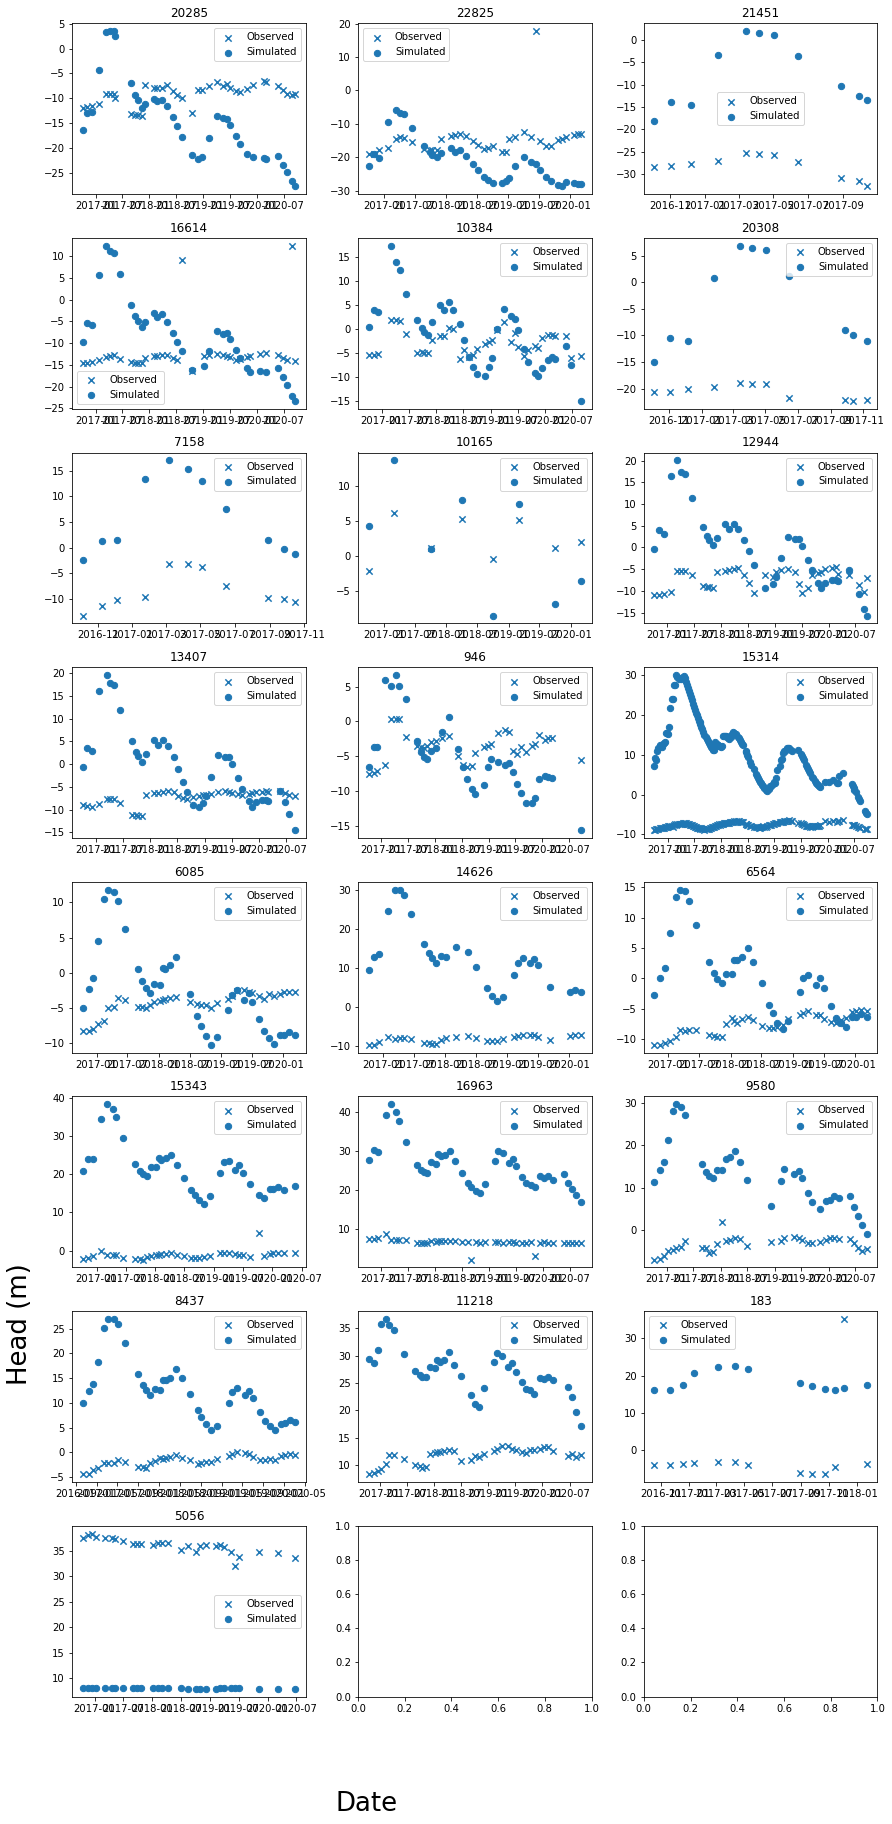

In [173]:
voi = [4579, 11218, 15343,
       14644, 14626, 11845,
       12511, 8594,10884,
       14789, 16614, 22825, 
      11078, 14972, 19794]
voi = hob_gpd[hob_gpd.SITE_CODE.isin(hobs_long)].node.unique()
# voi = 22825
# def obs_sim_node(voi):
ny = 3
nx = int(np.ceil(len(voi)/ny))
fig,ax=plt.subplots(nx,ny,figsize=(12,3*nx))
for i,voi_n in enumerate(voi):
    ax_n = ax[int(i / ny), i % ny] if (nx > 1) else ax[i]
    hob_gpd[hob_gpd.node==voi_n].reset_index().plot(x='MSMT_DATE',y='WSE',kind='scatter', ax=ax_n,
                                                  marker='x', s=40, label = 'Observed')
    hob_gpd[hob_gpd.node==voi_n].reset_index().plot(x='MSMT_DATE',y='sim_val',kind='scatter', ax=ax_n, 
                                                  marker='o', s=40,label='Simulated')
    ax_n.set_xlabel('')
    ax_n.set_ylabel('')
    ax_n.set_title(voi_n)
ax_n.legend()
fig.text(-0.03, 0.2, 'Head (m)',rotation='vertical',size=26)
fig.text(0.35, -0.05, 'Date',size=26)
fig.tight_layout()

# obs_sim_node(voi)
# hob_gpd[hob_gpd.node==22825].plot(x='MSMT_DATE',y='WSE',kind='scatter')


In [19]:
# hob_seasonal.loc[hob_seasonal.season=='spring'].plot('error',markersize='abs_error',scheme='Quantiles', k = 6,
#                   legend=True,cmap='bwr',legend_kwds={'loc':(1.1,0.8),'title':'Error (Obs - Sim)'})
# hob_seasonal.loc[hob_seasonal.season=='fall'].plot('error',markersize='abs_error',scheme='Quantiles', k = 6,
#                   legend=True,cmap='bwr',legend_kwds={'loc':(1.1,0.8),'title':'Error (Obs - Sim)'})

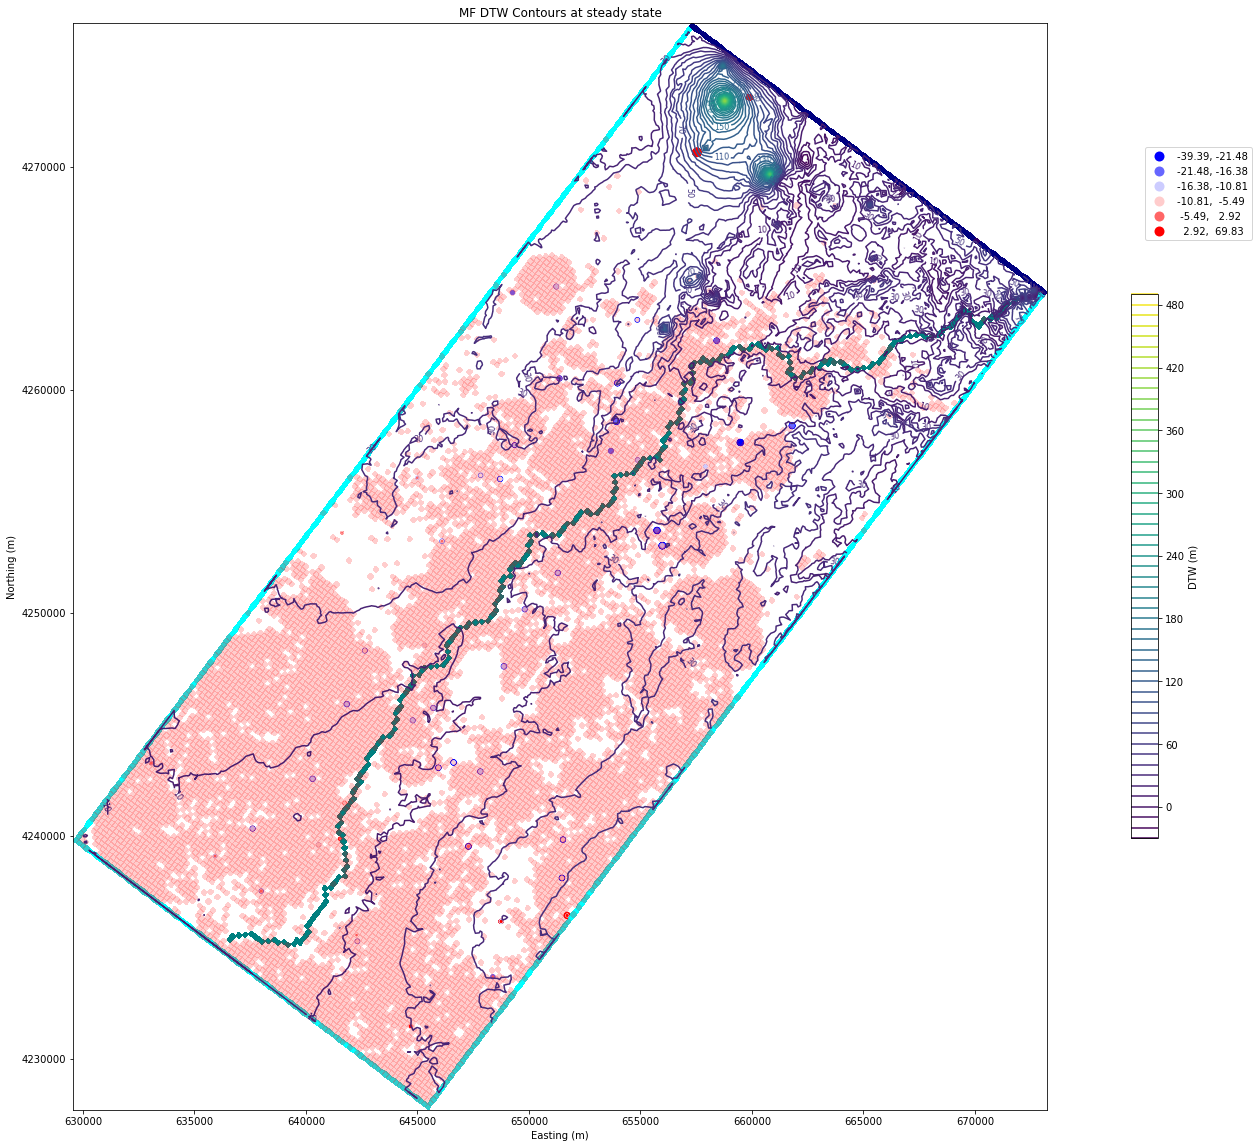

In [41]:
fig,ax = plt.subplots(figsize=(30, 20))
# plot_head(hdobj,cbb, spd_stp[180], 'Steady State',hk=False)

hob_gpd.plot('error',markersize='abs_error',scheme='Quantiles', k = 6, ax=ax,
                  legend=True,cmap='bwr',legend_kwds={'loc':(1.1,0.8)})
# plot_head_simple(m, hdobj, cbc, spd_stp[0], 'steady state', 'MF',ax=ax,hk=False,units='m')
plot_dtw_simple(m, hdobj, cbc, spd_stp[0], 'steady state', 'MF',ax=ax,hk=False,units='m')


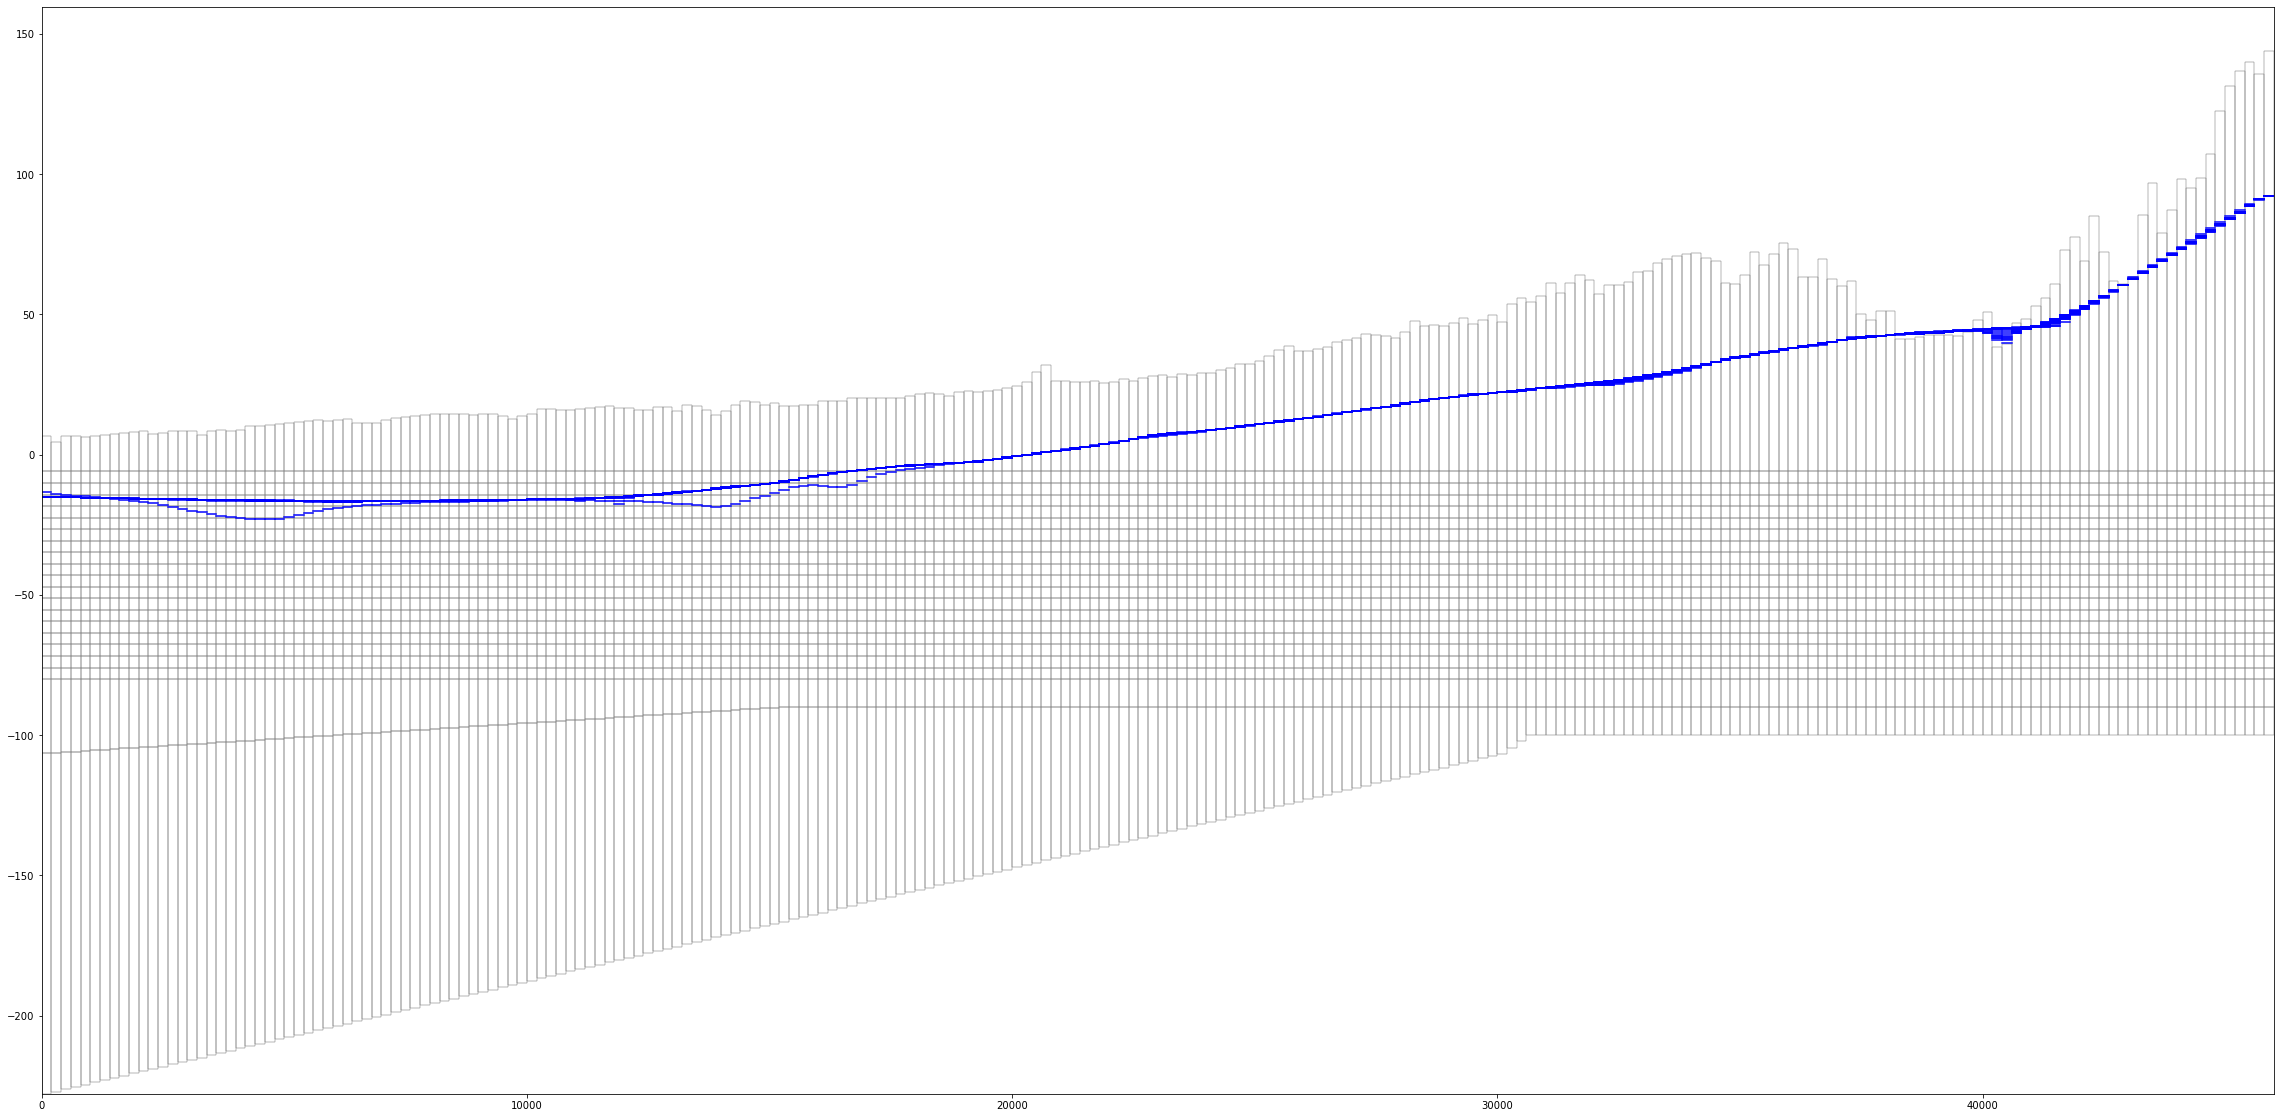

In [54]:
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(1, 1, 1)

head = hdobj.get_data(kstpkper = spd_stp[0])
head.shape
# head[:,rownum,:].shape

rownum = 80
mcs = flopy.plot.PlotCrossSection(model=m, line={'Row' : rownum})
linecollection = mcs.plot_grid(linewidth = 0.3)
ax.add_collection(linecollection)
# mcs.contour_array(a=head)
# mcs.plot_array(a=head)

wt = mcs.plot_surface(a=head[:,:,:])
